In [1]:
%matplotlib inline

# Assignment 5

**DUE: Sunday December 4, 2022 11:59pm**

Turn in the assignment via Canvas.

To write legible answers you will need to be familiar with both [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and [Latex](https://www.latex-tutorial.com/tutorials/amsmath/)

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Runtime→→Restart runtime) and then run all cells (in the menubar, select Runtime→→Run All).

Make sure you fill in any place that says "YOUR CODE HERE" or "YOUR ANSWER HERE", as well as your name below:

In [2]:
NAME = "Devan O'Boyle"
STUDENT_ID = "1829932"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

## Question 1: Bitcoin Price Prediction
---
Bitcoin, amongst other assets like AMC and GME, has been all the rage this past two years and reached an all time high of \$68,789.63 per bitcoin. Since reaching it's high, the price has dropped 75\%. Analysts continue to feed the frenzy by releasing price predictions that range from from \$500,000 to \$9,000 per bitcoin in the next year. You will make an Recurrent Neural Network model to gain some insight into price prediction. Yahoo! Finance is a trusted name in free financial information and has been with us since the internet's early years. You'll be using data gathered obtained from https://finance.yahoo.com/quote/BTC-USD/history/ to train your recurrent neural network.

Run the following code cell to download the training and test data. It might take a while to download the zip file and extract it.

Link to the raw data: [link](https://drive.google.com/file/d/1GqHXiTMdWfNniUfF0B5TkKnvMSV1kI4b)

In [4]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1GqHXiTMdWfNniUfF0B5TkKnvMSV1kI4b'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('BTC-USD.csv')


In [5]:
# Create pandas dataframe
data = pd.read_csv('BTC-USD.csv')

In [6]:
# Plot data.head()
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


Let's plot the bitcoin price. First, we will make a plot of bitcoin price vs the days after September 15, 2014, the start date of this dataset. Day "0" indicates September 15, 2014.

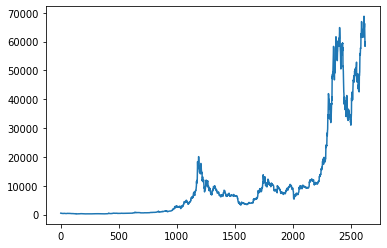

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns # Used for plotting

g = sns.lineplot(x = np.linspace(1,2622,2622), y = data['High'].values.reshape(-1))


Next, we plot bitcoin vs. days. But this time there are dates added to the graph.

[Text(0, 0, '2014-09-17'),
 Text(0, 0, '2015-04-05'),
 Text(0, 0, '2015-10-22'),
 Text(0, 0, '2016-05-09'),
 Text(0, 0, '2016-11-25'),
 Text(0, 0, '2017-06-13'),
 Text(0, 0, '2017-12-30'),
 Text(0, 0, '2018-07-18'),
 Text(0, 0, '2019-02-03'),
 Text(0, 0, '2019-08-22'),
 Text(0, 0, '2020-03-09'),
 Text(0, 0, '2020-09-25'),
 Text(0, 0, '2021-04-13')]

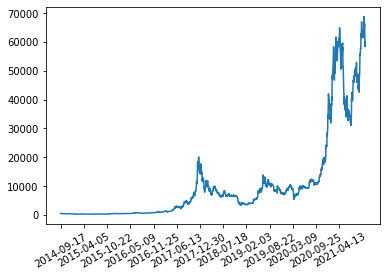

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns # Used for plotting

g = sns.lineplot(x = np.linspace(1,2622,2622), y = data['High'].values.reshape(-1))
g.set(xticks=np.arange(0,2500,200))
g.set_xticklabels(rotation=30, labels = data['Date'][0::200])

### Part a) Data Preprocessing (5 points)
In this section you will preprocess the data in order to train a recurrent neural network. We can see that there 5 columns, "Date", "Open", "High", "Low", "Close", "Adjusted Close", and "Volume". We will only use the High column.

In [9]:
# Create a dataframe that only contains High Column.
# Hint: it may be helpful to now cast your pruned dataframe to a numpy array.
from pandas import read_csv

data_high = read_csv('BTC-USD.csv', usecols=[2], engine = 'python')
print(data_high)


              High
0       468.174011
1       456.859985
2       427.834991
3       423.295990
4       412.425995
...            ...
2617  63721.195313
2618  60823.609375
2619  60948.500000
2620  58351.113281
2621  59859.878906

[2622 rows x 1 columns]


Remove missing values from the data.

In [10]:
# Remove enteries from the data with missing values. 
# The shape of the data after this step shoud be (2618,)

data_high = data_high.dropna()
dataset = data_high.values
dataset = dataset.astype('float32')
print(data_high.shape)

(2618, 1)



Recall [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) from sklearn. Use it to scale the data for our analysis. 

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

data_normalized = scaler.fit_transform(dataset)

You will implement a simple autoregressive recurrent neural network using the standard tensorflow RNN architectures. An autoregressive model originates from the literature on time-series models where observations from the previous time-steps are used to predict the value at the current time step. To implemement an autoregressive model, we will simply augment the data so that "time_steps" number of previous days are fed to the model at the current time step in order to form a prediction. The function to augment the data is given to you:

In [12]:
def create_dataset(dataset, time_steps=1):
    """
    Generate a dataset where the time series X[n] contains the readings for the 'time_step' previous days 
    and y contains the price for today.
    args:
    dataset: numpy array, the data
    time_steps: the number of previous days to feed to RNN

    returns:
    tuple: a dataset with x[i] containing 'time_step' number of previous prices, target price for x[i]
    """
    dataX, dataY = [], []
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_steps, 0])
    return np.array(dataX), np.array(dataY)

In [13]:
# Choose the number of time steps that the model "looks back"
time_steps = 1

# Produce your dataset based on the number of days the model could look back
train_size = int(len(data_normalized) * 0.8)
test_size = len(data_normalized) - train_size
train, test = data_normalized[0:train_size,:], data_normalized[train_size:len(data_normalized),:]
#train, test = train_test_split(data_normalized, test_size=0.2)
X_train, y_train = create_dataset(train, time_steps)
X_test, y_test = create_dataset(test, time_steps)

In [14]:
# Check the shape of your dataset; should be (2618-time_steps-1, time_steps) and (2618-time_steps-1,)
print(X_train.shape[0] + X_test.shape[0], X_train.shape[1])
print(y_train.shape[0] + y_test.shape[0])

2614 1
2614


### Part b) Data Partitioning (5 points)
Split data into train and test sets. Use 80\% for training and 20\% for testing. **Note**: you need to split the data in time (the begining 80\% of the days from start date will be the training data and the remaining 20\% will be test data).

In [15]:
### YOUR CODE HERE ###
# Already done



For this dataset, you need to reshape the partitions for the model to be able to process them.

In [16]:
# Reshape input to be [samples, time steps, features].
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# The shape of the training and test data after this step should be 
# ((2618-time_steps-1) * 80%, 1, time_steps) and ((2618-time_steps-1) * 20%, 1, time_steps), respectively.
X_train.shape

(2092, 1, 1)

In [17]:
X_test.shape

(522, 1, 1)

### Part c) RNN Model (15 points)
In this part you will create a model using an RNN layer (LSTM or GRU, unidirectional or bidirectional) and train it on your training data. You will also plot training and validation loss. Use mean squared error as your model's metric.

Compile your model and display the summary. Train the model and plot loss values.

In [18]:
# Build your model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(LSTM(2, input_shape=(1, time_steps)))
model.add(Dense(1))

In [19]:
batchsize = 1

epochs = 10

model.compile(loss = 'mean_squared_error', 
              optimizer = 'adam')

# Fit model - Use 20% validation split
history = model.fit(X_train, 
                 y_train,
                 epochs = 10,
                 batch_size = 1,
                 verbose = 2,
                 validation_split = 0.2)

Epoch 1/10
1673/1673 - 8s - loss: 0.0038 - val_loss: 0.0081 - 8s/epoch - 5ms/step
Epoch 2/10
1673/1673 - 4s - loss: 0.0030 - val_loss: 0.0069 - 4s/epoch - 2ms/step
Epoch 3/10
1673/1673 - 4s - loss: 9.8179e-04 - val_loss: 2.5818e-05 - 4s/epoch - 2ms/step
Epoch 4/10
1673/1673 - 4s - loss: 1.7876e-05 - val_loss: 2.4472e-05 - 4s/epoch - 2ms/step
Epoch 5/10
1673/1673 - 4s - loss: 1.7588e-05 - val_loss: 3.0376e-05 - 4s/epoch - 2ms/step
Epoch 6/10
1673/1673 - 4s - loss: 1.7009e-05 - val_loss: 2.7278e-05 - 4s/epoch - 2ms/step
Epoch 7/10
1673/1673 - 4s - loss: 1.6798e-05 - val_loss: 2.3484e-05 - 4s/epoch - 2ms/step
Epoch 8/10
1673/1673 - 4s - loss: 1.7324e-05 - val_loss: 2.4810e-05 - 4s/epoch - 3ms/step
Epoch 9/10
1673/1673 - 4s - loss: 1.5905e-05 - val_loss: 2.2652e-05 - 4s/epoch - 3ms/step
Epoch 10/10
1673/1673 - 4s - loss: 1.5803e-05 - val_loss: 2.3206e-05 - 4s/epoch - 2ms/step


Validation lowest loss: 1.5803085261723027e-05


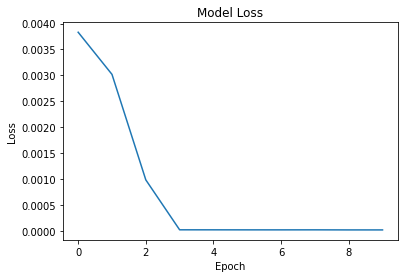

In [20]:
# Plot the model loss

def plot_losses(hist):
    print('Validation lowest loss:', min(hist.history['loss']))
    plt.plot(hist.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

plot_losses(history)

### Part d) More Advanced RNN Model (15 points)
In this part you will create an RNN model with the number of layers and architerure you prefer. Train it on your training data. You will also plot training and validation loss. Again, use mean squared error as your metric. In this part, you can try different models and use different hyper-parameters and report only the best one.

Compile your model and display the summary:

In [21]:
# Build your model

### YOUR CODE HERE ###

model = Sequential()
#model.add(LSTM(200, input_shape=(1, time_steps)))
model.add(LSTM(20, return_sequences = True, input_shape=(1, time_steps)))
model.add(LSTM(10))
model.add(Dense(1))

In [22]:
batchsize = 1

epochs = 10

model.compile(loss = 'mean_squared_error', 
              optimizer = 'rmsprop',
              metrics = ['accuracy'])

# Fit model
history = model.fit(X_train, 
                 y_train,
                 epochs = 10,
                 batch_size = 1,
                 verbose = 2,
                 validation_split=0.2)

Epoch 1/10
1673/1673 - 10s - loss: 7.7572e-04 - accuracy: 5.9773e-04 - val_loss: 4.4793e-05 - val_accuracy: 0.0000e+00 - 10s/epoch - 6ms/step
Epoch 2/10
1673/1673 - 7s - loss: 2.8073e-05 - accuracy: 5.9773e-04 - val_loss: 3.1239e-05 - val_accuracy: 0.0000e+00 - 7s/epoch - 4ms/step
Epoch 3/10
1673/1673 - 7s - loss: 2.5716e-05 - accuracy: 5.9773e-04 - val_loss: 3.1808e-05 - val_accuracy: 0.0000e+00 - 7s/epoch - 4ms/step
Epoch 4/10
1673/1673 - 7s - loss: 2.3937e-05 - accuracy: 5.9773e-04 - val_loss: 3.8656e-05 - val_accuracy: 0.0000e+00 - 7s/epoch - 4ms/step
Epoch 5/10
1673/1673 - 7s - loss: 2.4305e-05 - accuracy: 5.9773e-04 - val_loss: 2.2549e-05 - val_accuracy: 0.0000e+00 - 7s/epoch - 4ms/step
Epoch 6/10
1673/1673 - 7s - loss: 2.2930e-05 - accuracy: 5.9773e-04 - val_loss: 2.9557e-05 - val_accuracy: 0.0000e+00 - 7s/epoch - 4ms/step
Epoch 7/10
1673/1673 - 7s - loss: 2.1292e-05 - accuracy: 5.9773e-04 - val_loss: 3.3116e-05 - val_accuracy: 0.0000e+00 - 7s/epoch - 4ms/step
Epoch 8/10
1673/16

Validation lowest loss: 2.1291909433784895e-05


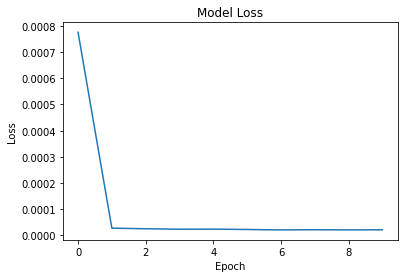

In [23]:
# Plot the model loss

def plot_losses(hist):
    print('Validation lowest loss:', min(hist.history['loss']))
    plt.plot(hist.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

plot_losses(history)

### Part e) Looking at the Predictions (10 points)
Now, Using the final (best) model you trained, show your model's performance on the test set. Plot the model's prediction for Bitcoin Price along with the actual test set prices. Lastly, note how your model's predictions change with your model's architecture and the number of days you "look back". Does your model perform better with more "look back days" or less. Did adding more layers help?

**Note:** Your model is trained on normalized data. In order to transform your model's predictions to the original price range you will likely need to use sklearn's inverse_transform (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

17/17 [==============================] - 0s 2ms/step
(2092,)
Train Score: 263.7108 RMSE
Test Score:  5642.9244 RMSE


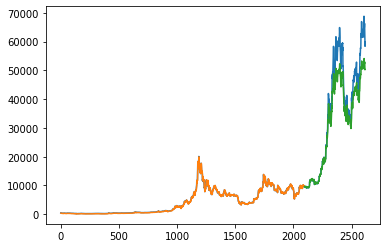

In [24]:
### YOUR CODE HERE ###
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

print(y_train.shape)

trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

trainScore = np.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score:', np.round(trainScore, 4), 'RMSE')

y_test[0] = np.nan_to_num(y_test[0])
testPredict[:,0] = np.nan_to_num(testPredict[:,0])
testScore = np.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: ', np.round(testScore, 4), 'RMSE')

train_pred = np.empty_like(data_normalized)
train_pred[:,:] = np.nan
train_pred[time_steps:len(trainPredict) + time_steps,:] = trainPredict

test_pred = np.empty_like(data_normalized)
test_pred[:,:] = np.nan
test_pred[len(trainPredict) + (time_steps*2)+1:len(data_normalized)-1,:] = testPredict

plt.plot(scaler.inverse_transform(data_normalized))
plt.plot(train_pred)
plt.plot(test_pred)
plt.show()



I've found that the model performs better with more look back days since it results in less loss. I also found the model performed better the with the more layers I added.

## Question 2: Reuters Topic Classification
---
We will use the [Reuters newswire](https://keras.io/api/datasets/reuters/) classification dataset, which has text paired with 46 topics as labels. You can see what these labels represent [here](https://martin-thoma.com/nlp-reuters/). You will analyze the text and classify the text into one of the 46 classes. Classes are the defined based on the following list (in the same order):
>```
['cocoa','grain','veg-oil','earn','acq','wheat','copper',
'housing','money-supply','coffee','sugar','trade','reserves',
'ship','cotton','carcass','crude','nat-gas','cpi','money-fx',
'interest','gnp','meal-feed','alum','oilseed','gold','tin',
'strategic-metal','livestock','retail','ipi','iron-steel',
'rubber','heat','jobs','lei','bop','zinc','orange',
'pet-chem','dlr','gas','silver','wpi','hog','lead']
```



### Part a) Processing the Data (5 points)
Load the data simply from Keras: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/reuters/load_data.
You also need to follow the RNN handout from the class exercise and prepare encoding and decoding functions and any other pre-processing you might find useful.

Print 5 examples of news along with their class label. 

In [25]:
# Load data
from tensorflow.keras.preprocessing.sequence import pad_sequences

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.reuters.load_data(num_words=5000)

# Print sample data
print(X_train[-1])
### YOUR CODE HERE ###

X_train = pad_sequences(X_train, maxlen=5000)
X_test = pad_sequences(X_test, maxlen=5000)

encoded_y_train = tf.keras.utils.to_categorical(y_train)
encoded_y_test = tf.keras.utils.to_categorical(y_test)

[1, 227, 2406, 91, 2, 125, 2855, 21, 4, 3976, 76, 7, 4, 757, 481, 3976, 790, 2, 2, 9, 111, 149, 8, 7, 10, 76, 223, 51, 4, 417, 8, 1047, 91, 2, 1688, 340, 7, 194, 2, 6, 1894, 21, 127, 2151, 2394, 1456, 6, 3034, 4, 329, 433, 7, 65, 87, 1127, 10, 2, 1475, 290, 9, 21, 567, 16, 1926, 24, 4, 76, 209, 30, 4033, 2, 2, 8, 4, 60, 8, 4, 966, 308, 40, 2575, 129, 2, 295, 277, 1071, 9, 24, 286, 2114, 234, 222, 9, 4, 906, 3994, 2, 114, 2, 1752, 7, 4, 113, 17, 12]


### Part b) Data Partitioning (5 points)

Split data into train and test sets. Please use 80% for training and 20% for testing. Note that we want to have the same distribution of labels in the training and test set, so you can use stratified train-test split of Keras. See here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [26]:
### YOUR CODE HERE ###
# Already done
print(len(X_test))
print(len(X_train))

2246
8982


### Part c) Simple RNN Model (15 points)

Create a model using an RNN layer (LSTM or GRU, unidirectional or bidirectional) and train it on your training data. You will also plot training and validation loss and your accuracy metric.

Compile your model and display the summary:

In [27]:
# Build your model
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, LSTM
from tensorflow.keras.models import Sequential

### YOUR CODE HERE ###

sent_model = Sequential()
sent_model.add(Embedding(5000, 100, input_length = 5000))
sent_model.add(LSTM(100))
sent_model.add(Dense(46, activation='softmax'))

sent_model.compile(loss= 'categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

sent_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5000, 100)         500000    
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 46)                4646      
                                                                 
Total params: 585,046
Trainable params: 585,046
Non-trainable params: 0
_________________________________________________________________


In [28]:

# Fit model
history = sent_model.fit(X_train, encoded_y_train, batch_size=300, epochs=10, validation_split=0.2, shuffle=True)

Epoch 1/10
24/24 [==============================] - 10s 346ms/step - loss: 2.6694 - accuracy: 0.3503 - val_loss: 2.6756 - val_accuracy: 0.3450
Epoch 2/10
24/24 [==============================] - 8s 318ms/step - loss: 2.2165 - accuracy: 0.4501 - val_loss: 2.0496 - val_accuracy: 0.4608
Epoch 3/10
24/24 [==============================] - 8s 320ms/step - loss: 1.9929 - accuracy: 0.4891 - val_loss: 1.9024 - val_accuracy: 0.4947
Epoch 4/10
24/24 [==============================] - 8s 320ms/step - loss: 1.8752 - accuracy: 0.5035 - val_loss: 1.7439 - val_accuracy: 0.5492
Epoch 5/10
24/24 [==============================] - 8s 321ms/step - loss: 1.7599 - accuracy: 0.5396 - val_loss: 1.7632 - val_accuracy: 0.5281
Epoch 6/10
24/24 [==============================] - 8s 320ms/step - loss: 1.6878 - accuracy: 0.5517 - val_loss: 1.6698 - val_accuracy: 0.5643
Epoch 7/10
24/24 [==============================] - 8s 321ms/step - loss: 1.6243 - accuracy: 0.5687 - val_loss: 1.6372 - val_accuracy: 0.5804
Epoch

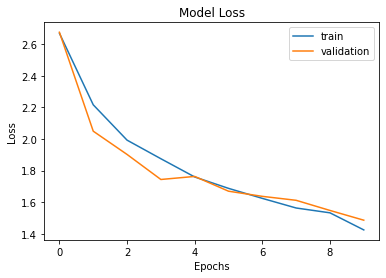

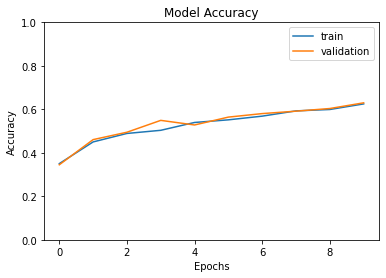

In [29]:
# Plot the model loss and accuracy on training and validation sets

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.ylim([0,1])
plt.show()

### Part d) More Advanced RNN Model (15 points)
In this part, you will create an RNN model with the number of layers and architerure you prefer. Train it on your training data. You will also plot training and validation loss and your metric. In this part, you can try different models and use different hyper-parameters and report only the best one.

Compile your model and display the summary:

In [30]:
# Build your model
from tensorflow.keras.layers import Conv1D, MaxPool1D
### YOUR CODE HERE ###


sent_model = Sequential()
sent_model.add(Embedding(5000, 100, input_length = 5000))
sent_model.add(LSTM(200))
sent_model.add(Dense(100, kernel_regularizer=tf.keras.regularizers.l1(0.001),activation='relu'))
sent_model.add(Dense(46, activation='softmax'))


sent_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

sent_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 5000, 100)         500000    
                                                                 
 lstm_4 (LSTM)               (None, 200)               240800    
                                                                 
 dense_3 (Dense)             (None, 100)               20100     
                                                                 
 dense_4 (Dense)             (None, 46)                4646      
                                                                 
Total params: 765,546
Trainable params: 765,546
Non-trainable params: 0
_________________________________________________________________


In [31]:


# Fit model
history = sent_model.fit(X_train, encoded_y_train, batch_size=256, epochs=10, validation_split=0.2, shuffle=True)

Epoch 1/10
29/29 [==============================] - 12s 345ms/step - loss: 3.7975 - accuracy: 0.3198 - val_loss: 3.5125 - val_accuracy: 0.3450
Epoch 2/10
29/29 [==============================] - 10s 329ms/step - loss: 3.2673 - accuracy: 0.3464 - val_loss: 3.2986 - val_accuracy: 0.3450
Epoch 3/10
29/29 [==============================] - 9s 329ms/step - loss: 2.7821 - accuracy: 0.4465 - val_loss: 2.5689 - val_accuracy: 0.4791
Epoch 4/10
29/29 [==============================] - 10s 329ms/step - loss: 2.4821 - accuracy: 0.4814 - val_loss: 2.3260 - val_accuracy: 0.4741
Epoch 5/10
29/29 [==============================] - 10s 329ms/step - loss: 2.2649 - accuracy: 0.4949 - val_loss: 2.3023 - val_accuracy: 0.4836
Epoch 6/10
29/29 [==============================] - 10s 330ms/step - loss: 2.0701 - accuracy: 0.5272 - val_loss: 2.1605 - val_accuracy: 0.5225
Epoch 7/10
29/29 [==============================] - 10s 329ms/step - loss: 1.9853 - accuracy: 0.5463 - val_loss: 2.3649 - val_accuracy: 0.4302


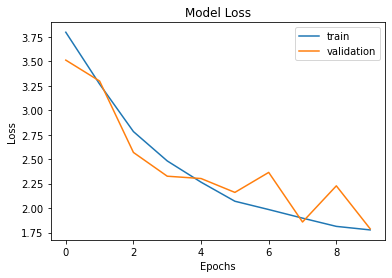

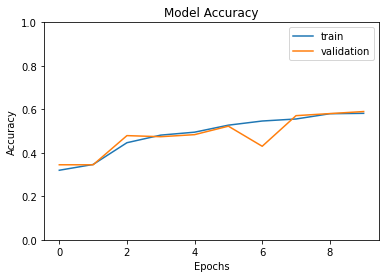

In [32]:
# Plot the model loss and accuracy

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.ylim([0,1])
plt.show()

### Part e) Looking at the Predictions (10 points)

Now, Using the final (best) model you trained, show your model's performance on the test set.
Calculate and display the prediction accuracy for all of the 46 different classes. 

In [33]:
train_pred = sent_model.predict(X_test)
train_pred = np.array(train_pred)

71/71 [==============================] - 7s 99ms/step


In [36]:
class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper',
'housing','money-supply','coffee','sugar','trade','reserves',
'ship','cotton','carcass','crude','nat-gas','cpi','money-fx',
'interest','gnp','meal-feed','alum','oilseed','gold','tin',
'strategic-metal','livestock','retail','ipi','iron-steel',
'rubber','heat','jobs','lei','bop','zinc','orange',
'pet-chem','dlr','gas','silver','wpi','hog','lead']

In [47]:
### YOUR CODE HERE ###

y_pred = np.argmax(a = train_pred, axis=1)
valid = [0]*46
total = [0]*46
all_pred = [0]*46
for i in range(0, len(y_pred)):
    total[y_test[i]] += 1
    all_pred[y_pred[i]] += 1
    if y_pred[i] == y_test[i]:
        valid[y_test[i]] = valid[y_test[i]]+1

for i in range(0, len(class_names)):
    print(i, class_names[i], f'\t\t% valid = {valid[i]/total[i] * 100:.2f}')

0 cocoa 		% valid = 0.00
1 grain 		% valid = 42.86
2 veg-oil 		% valid = 0.00
3 earn 		% valid = 93.11
4 acq 		% valid = 86.08
5 wheat 		% valid = 0.00
6 copper 		% valid = 0.00
7 housing 		% valid = 0.00
8 money-supply 		% valid = 0.00
9 coffee 		% valid = 0.00
10 sugar 		% valid = 0.00
11 trade 		% valid = 0.00
12 reserves 		% valid = 0.00
13 ship 		% valid = 0.00
14 cotton 		% valid = 0.00
15 carcass 		% valid = 0.00
16 crude 		% valid = 0.00
17 nat-gas 		% valid = 0.00
18 cpi 		% valid = 0.00
19 money-fx 		% valid = 70.68
20 interest 		% valid = 0.00
21 gnp 		% valid = 0.00
22 meal-feed 		% valid = 0.00
23 alum 		% valid = 0.00
24 oilseed 		% valid = 0.00
25 gold 		% valid = 0.00
26 tin 		% valid = 0.00
27 strategic-metal 		% valid = 0.00
28 livestock 		% valid = 0.00
29 retail 		% valid = 0.00
30 ipi 		% valid = 0.00
31 iron-steel 		% valid = 0.00
32 rubber 		% valid = 0.00
33 heat 		% valid = 0.00
34 jobs 		% valid = 0.00
35 lei 		% valid = 0.00
36 bop 		% valid = 0.00
37 zinc 		